In [1]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import torch
import torchvision
from torch import nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import albumentations as A
from albumentations import RandomRotate90,Resize
import yaml
from torchvision.utils import save_image
import torch.nn.functional as F
from tqdm import tqdm
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
import pdb
from dataloader import Dataset,DatasetWithDB
from arch.unet import U_Net
from arch1.Adaptive_Scale import AdaptiveScale
from metrics import iou_score,relative_volume_difference,torch2D_Hausdorff_distance
from utils import AverageMeter
from losses import AdaptiveScaleLoss

## param

In [2]:
config = {}
# config['name'] = 'ISIC_1111_AdaptiveScale_with_unet'
# config['dataset'] = 'ISIC'
# config['name'] = 'BUSI_1105_AdaptiveScale_with_unet'
# config['dataset'] = 'Dataset_BUSI_with_GT'
config['name'] = 'Kvasir-SEG_1119_AdaptiveScale_with_UNet'
config['dataset'] = 'Kvasir-SEG'

config['epochs'] = 200
config['input_channels'] = 3
config['output_channels'] = 1
config['input_hw'] = 512
config['lr'] = 1e-4
config['momentum'] = 0.9
config['weight_decay'] = 3e-4
config['batch_size'] = 4
config['num_workers'] = 4
config['min_lr'] = 1e-6
config['result_dir'] = os.path.join('./result',config['name'])
config['isPretrain'] = False
config['pretrain_name'] = 'BUSI_1029_AdaptiveScale_with_unet'
if not os.path.exists(os.path.join('./result',config['pretrain_name'])):
    config['pretrain_dir'] = None
else :
    config['pretrain_dir'] = os.path.join('./result',config['pretrain_name'])
config

{'name': 'Kvasir-SEG_1119_AdaptiveScale_with_UNet',
 'dataset': 'Kvasir-SEG',
 'epochs': 200,
 'input_channels': 3,
 'output_channels': 1,
 'input_hw': 512,
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0.0003,
 'batch_size': 4,
 'num_workers': 4,
 'min_lr': 1e-06,
 'result_dir': './result/Kvasir-SEG_1119_AdaptiveScale_with_UNet',
 'isPretrain': False,
 'pretrain_name': 'BUSI_1029_AdaptiveScale_with_unet',
 'pretrain_dir': './result/BUSI_1029_AdaptiveScale_with_unet'}

In [3]:
if not os.path.exists(config['result_dir']):
    os.makedirs(config['result_dir'])

## dataset

In [4]:
train_img_ids = np.load(os.path.join('./datasets',config['dataset'],'train_img_ids.npy'))
valid_img_ids = np.load(os.path.join('./datasets',config['dataset'],'valid_img_ids.npy'))

In [5]:
train_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    # A.RandomBrightnessContrast(p=0.2),   # 随机明亮对比度
])
# train_transform = A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.GaussNoise(),    # 将高斯噪声应用于输入图像。
#         A.OneOf([
#             A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
#             A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
#             A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
#         ], p=0.2),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#         # 随机应用仿射变换：平移，缩放和旋转输入
#         A.RandomBrightnessContrast(p=0.2),   # 随机明亮对比度
#     ])

train_dataset = DatasetWithDB(
    dataset=config['dataset'],
    img_names=train_img_ids,
    transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'])

# 没有测试集么？
valid_transform = A.Compose([
#     A.Normalize(),  # 也不需要
])

valid_dataset = DatasetWithDB(
    dataset=config['dataset'],
    img_names=valid_img_ids,
    transform=valid_transform
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'])

## model

In [6]:
model = AdaptiveScale(U_Net(in_ch=3, out_ch=1),in_channels=1,out_channels=1)
device = torch.device('cuda')
model = model.to(device)
# print(a)
X = torch.rand(size=(2,3,256,256),dtype=torch.float32)
X = X.to(device)
print(model(X).shape)
del model
del X
torch.cuda.empty_cache()

torch.Size([2, 3, 256, 256])


## train

In [7]:
def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input_, label_ in train_loader:
#         print("train:",input_.max(),input_.min(),target_.max(),target_.min())
        input_ = input_.to(device,dtype=torch.float32)
        label_ = label_.to(device,dtype=torch.float32)

        output = model(input_)
        loss = criterion(output, label_)
        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        iou,dice = iou_score(output[:,2:3,:,:], label_[:,2:3,:,:])
        avg_meters['loss'].update(loss.item(), input_.size(0))
        avg_meters['iou'].update(iou, input_.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])

## valid

In [8]:
def validate(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                   'dice': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input_, label_ in val_loader:
            input_ = input_.to(device,dtype=torch.float32)
            label_ = label_.to(device,dtype=torch.float32)
            
            output = model(input_)
            loss = criterion(output, label_)
            iou,dice = iou_score(output[:,2:3,:,:], label_[:,2:3,:,:])

            avg_meters['loss'].update(loss.item(), input_.size(0))
            avg_meters['iou'].update(iou, input_.size(0))
            avg_meters['dice'].update(dice, input_.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

## run

In [9]:
cudnn.benchmark = True
criterion = AdaptiveScaleLoss(base_loss=nn.BCEWithLogitsLoss()).cuda()
# criterion = nn.BCEWithLogitsLoss().cuda()
model = AdaptiveScale(U_Net(in_ch=3, out_ch=1),in_channels=1,out_channels=1, hidden_dim=16)
if config['isPretrain'] and config['pretrain_dir'] is not None:
    print("loading model...")
    model.load_state_dict(torch.load(os.path.join(config['pretrain_dir'],'model.pth')),strict=True)
    print("load model success!")
else:
    print("no pretrain")
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=config['min_lr'])

log = OrderedDict([
    ('epoch', []),
    ('lr', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
    ('val_dice', []),
])

best_iou = 0

start_time = time.time()
for epoch in range(config['epochs']):
    print('Epoch [%d/%d]' % (epoch, config['epochs']))
    # train for one epoch
    train_log = train(config, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(config, valid_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
          % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))
    log['epoch'].append(epoch)
    log['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])
    log['val_dice'].append(val_log['dice'])

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), 'result/%s/model.pth' %
                   config['name'])
        best_iou = val_log['iou']
        print("=> saved best model")
    
    pd.DataFrame(log).to_csv('result/%s/log.csv' %
                         config['name'], index=False)
    scheduler.step()
    torch.cuda.empty_cache()
end_time = time.time()
print("best iou: %.4f"%best_iou)
print('Running time: %s Seconds' % (end_time - start_time))

no pretrain
Epoch [0/200]


100%|██████████| 33/33 [00:00<00:00, 54.56it/s, loss=1.55, iou=0.000456, dice=0.00091] 


loss 1.9680 - iou 0.0595 - val_loss 1.5505 - val_iou 0.0005
=> saved best model
Epoch [1/200]


100%|██████████| 33/33 [00:00<00:00, 54.68it/s, loss=1.26, iou=6.44e-10, dice=1.29e-9]


loss 1.4712 - iou 0.0000 - val_loss 1.2602 - val_iou 0.0000
Epoch [2/200]


100%|██████████| 33/33 [00:00<00:00, 53.25it/s, loss=1.12, iou=6.44e-10, dice=1.29e-9]


loss 1.2265 - iou 0.0000 - val_loss 1.1164 - val_iou 0.0000
Epoch [3/200]


100%|██████████| 33/33 [00:00<00:00, 55.22it/s, loss=1.06, iou=0.349, dice=0.496]


loss 1.1272 - iou 0.1630 - val_loss 1.0563 - val_iou 0.3485
=> saved best model
Epoch [4/200]


100%|██████████| 33/33 [00:00<00:00, 54.32it/s, loss=1.02, iou=0.388, dice=0.536]


loss 1.0735 - iou 0.3032 - val_loss 1.0232 - val_iou 0.3883
=> saved best model
Epoch [5/200]


100%|██████████| 33/33 [00:00<00:00, 53.82it/s, loss=0.976, iou=0.427, dice=0.575]


loss 1.0394 - iou 0.3485 - val_loss 0.9761 - val_iou 0.4272
=> saved best model
Epoch [6/200]


100%|██████████| 33/33 [00:00<00:00, 52.06it/s, loss=0.975, iou=0.446, dice=0.583]


loss 1.0184 - iou 0.3832 - val_loss 0.9747 - val_iou 0.4461
=> saved best model
Epoch [7/200]


100%|██████████| 33/33 [00:00<00:00, 54.34it/s, loss=0.933, iou=0.499, dice=0.633]


loss 1.0043 - iou 0.3922 - val_loss 0.9335 - val_iou 0.4990
=> saved best model
Epoch [8/200]


100%|██████████| 33/33 [00:00<00:00, 54.80it/s, loss=0.918, iou=0.54, dice=0.682] 


loss 0.9991 - iou 0.4008 - val_loss 0.9180 - val_iou 0.5399
=> saved best model
Epoch [9/200]


100%|██████████| 33/33 [00:00<00:00, 55.73it/s, loss=0.919, iou=0.547, dice=0.684]


loss 0.9797 - iou 0.4309 - val_loss 0.9188 - val_iou 0.5466
=> saved best model
Epoch [10/200]


100%|██████████| 33/33 [00:00<00:00, 52.40it/s, loss=0.933, iou=0.456, dice=0.596]


loss 0.9782 - iou 0.4259 - val_loss 0.9328 - val_iou 0.4559
Epoch [11/200]


100%|██████████| 33/33 [00:00<00:00, 53.45it/s, loss=0.9, iou=0.588, dice=0.724]  


loss 0.9721 - iou 0.4345 - val_loss 0.9002 - val_iou 0.5881
=> saved best model
Epoch [12/200]


100%|██████████| 33/33 [00:00<00:00, 53.93it/s, loss=0.895, iou=0.583, dice=0.718]


loss 0.9668 - iou 0.4459 - val_loss 0.8951 - val_iou 0.5833
Epoch [13/200]


100%|██████████| 33/33 [00:00<00:00, 53.33it/s, loss=0.907, iou=0.567, dice=0.701]


loss 0.9581 - iou 0.4777 - val_loss 0.9075 - val_iou 0.5668
Epoch [14/200]


100%|██████████| 33/33 [00:00<00:00, 53.36it/s, loss=0.894, iou=0.582, dice=0.711]


loss 0.9577 - iou 0.4665 - val_loss 0.8938 - val_iou 0.5822
Epoch [15/200]


100%|██████████| 33/33 [00:00<00:00, 53.37it/s, loss=0.893, iou=0.551, dice=0.686]


loss 0.9552 - iou 0.4597 - val_loss 0.8929 - val_iou 0.5506
Epoch [16/200]


100%|██████████| 33/33 [00:00<00:00, 51.88it/s, loss=0.89, iou=0.477, dice=0.624] 


loss 0.9453 - iou 0.4942 - val_loss 0.8897 - val_iou 0.4772
Epoch [17/200]


100%|██████████| 33/33 [00:00<00:00, 50.43it/s, loss=0.879, iou=0.557, dice=0.693]


loss 0.9447 - iou 0.4781 - val_loss 0.8788 - val_iou 0.5567
Epoch [18/200]


100%|██████████| 33/33 [00:00<00:00, 54.99it/s, loss=0.878, iou=0.603, dice=0.735]


loss 0.9321 - iou 0.5068 - val_loss 0.8776 - val_iou 0.6029
=> saved best model
Epoch [19/200]


100%|██████████| 33/33 [00:00<00:00, 55.54it/s, loss=0.864, iou=0.613, dice=0.745]


loss 0.9434 - iou 0.5013 - val_loss 0.8639 - val_iou 0.6133
=> saved best model
Epoch [20/200]


100%|██████████| 33/33 [00:00<00:00, 55.03it/s, loss=0.879, iou=0.597, dice=0.735]


loss 0.9404 - iou 0.4866 - val_loss 0.8792 - val_iou 0.5975
Epoch [21/200]


100%|██████████| 33/33 [00:00<00:00, 53.52it/s, loss=0.865, iou=0.587, dice=0.716]


loss 0.9309 - iou 0.5247 - val_loss 0.8646 - val_iou 0.5874
Epoch [22/200]


100%|██████████| 33/33 [00:00<00:00, 56.02it/s, loss=0.875, iou=0.614, dice=0.742]


loss 0.9386 - iou 0.4961 - val_loss 0.8751 - val_iou 0.6141
=> saved best model
Epoch [23/200]


100%|██████████| 33/33 [00:00<00:00, 52.34it/s, loss=0.868, iou=0.616, dice=0.746]


loss 0.9255 - iou 0.5231 - val_loss 0.8683 - val_iou 0.6160
=> saved best model
Epoch [24/200]


100%|██████████| 33/33 [00:00<00:00, 54.44it/s, loss=0.863, iou=0.619, dice=0.751]


loss 0.9216 - iou 0.5107 - val_loss 0.8625 - val_iou 0.6188
=> saved best model
Epoch [25/200]


100%|██████████| 33/33 [00:00<00:00, 53.99it/s, loss=0.871, iou=0.599, dice=0.726]


loss 0.9177 - iou 0.5445 - val_loss 0.8705 - val_iou 0.5989
Epoch [26/200]


100%|██████████| 33/33 [00:00<00:00, 53.53it/s, loss=0.884, iou=0.627, dice=0.761]


loss 0.9154 - iou 0.5460 - val_loss 0.8842 - val_iou 0.6271
=> saved best model
Epoch [27/200]


100%|██████████| 33/33 [00:00<00:00, 55.61it/s, loss=0.854, iou=0.618, dice=0.75] 


loss 0.9180 - iou 0.5304 - val_loss 0.8541 - val_iou 0.6180
Epoch [28/200]


100%|██████████| 33/33 [00:00<00:00, 53.79it/s, loss=0.857, iou=0.617, dice=0.743]


loss 0.9144 - iou 0.5345 - val_loss 0.8571 - val_iou 0.6170
Epoch [29/200]


100%|██████████| 33/33 [00:00<00:00, 54.39it/s, loss=0.864, iou=0.609, dice=0.743]


loss 0.9117 - iou 0.5439 - val_loss 0.8635 - val_iou 0.6088
Epoch [30/200]


100%|██████████| 33/33 [00:00<00:00, 54.33it/s, loss=0.858, iou=0.61, dice=0.746] 


loss 0.9053 - iou 0.5591 - val_loss 0.8576 - val_iou 0.6098
Epoch [31/200]


100%|██████████| 33/33 [00:00<00:00, 54.30it/s, loss=0.864, iou=0.628, dice=0.762]


loss 0.9035 - iou 0.5569 - val_loss 0.8639 - val_iou 0.6282
=> saved best model
Epoch [32/200]


100%|██████████| 33/33 [00:00<00:00, 51.90it/s, loss=0.854, iou=0.646, dice=0.771]


loss 0.9021 - iou 0.5575 - val_loss 0.8536 - val_iou 0.6462
=> saved best model
Epoch [33/200]


100%|██████████| 33/33 [00:00<00:00, 54.80it/s, loss=0.861, iou=0.61, dice=0.745] 


loss 0.9022 - iou 0.5673 - val_loss 0.8612 - val_iou 0.6100
Epoch [34/200]


100%|██████████| 33/33 [00:00<00:00, 54.57it/s, loss=0.871, iou=0.574, dice=0.713]


loss 0.9020 - iou 0.5804 - val_loss 0.8710 - val_iou 0.5740
Epoch [35/200]


100%|██████████| 33/33 [00:00<00:00, 53.18it/s, loss=0.864, iou=0.588, dice=0.724]


loss 0.8993 - iou 0.5597 - val_loss 0.8643 - val_iou 0.5876
Epoch [36/200]


100%|██████████| 33/33 [00:00<00:00, 53.87it/s, loss=0.863, iou=0.585, dice=0.721]


loss 0.8967 - iou 0.5800 - val_loss 0.8633 - val_iou 0.5855
Epoch [37/200]


100%|██████████| 33/33 [00:00<00:00, 52.60it/s, loss=0.86, iou=0.641, dice=0.767] 


loss 0.8892 - iou 0.5816 - val_loss 0.8600 - val_iou 0.6415
Epoch [38/200]


100%|██████████| 33/33 [00:00<00:00, 52.86it/s, loss=0.847, iou=0.64, dice=0.77]  


loss 0.8886 - iou 0.5878 - val_loss 0.8467 - val_iou 0.6398
Epoch [39/200]


100%|██████████| 33/33 [00:00<00:00, 53.29it/s, loss=0.859, iou=0.641, dice=0.77] 


loss 0.8970 - iou 0.5668 - val_loss 0.8587 - val_iou 0.6407
Epoch [40/200]


100%|██████████| 33/33 [00:00<00:00, 52.05it/s, loss=0.851, iou=0.597, dice=0.734]


loss 0.8873 - iou 0.5861 - val_loss 0.8514 - val_iou 0.5973
Epoch [41/200]


100%|██████████| 33/33 [00:00<00:00, 55.40it/s, loss=0.852, iou=0.632, dice=0.76] 


loss 0.8846 - iou 0.5982 - val_loss 0.8519 - val_iou 0.6316
Epoch [42/200]


100%|██████████| 33/33 [00:00<00:00, 55.31it/s, loss=0.851, iou=0.658, dice=0.786]


loss 0.8895 - iou 0.5909 - val_loss 0.8509 - val_iou 0.6577
=> saved best model
Epoch [43/200]


100%|██████████| 33/33 [00:00<00:00, 53.55it/s, loss=0.853, iou=0.637, dice=0.77] 


loss 0.8811 - iou 0.5955 - val_loss 0.8527 - val_iou 0.6374
Epoch [44/200]


100%|██████████| 33/33 [00:00<00:00, 54.87it/s, loss=0.854, iou=0.62, dice=0.756] 


loss 0.8760 - iou 0.6156 - val_loss 0.8535 - val_iou 0.6201
Epoch [45/200]


100%|██████████| 33/33 [00:00<00:00, 52.97it/s, loss=0.853, iou=0.626, dice=0.756]


loss 0.8724 - iou 0.6254 - val_loss 0.8531 - val_iou 0.6257
Epoch [46/200]


100%|██████████| 33/33 [00:00<00:00, 55.15it/s, loss=0.855, iou=0.639, dice=0.769]


loss 0.8834 - iou 0.6057 - val_loss 0.8554 - val_iou 0.6385
Epoch [47/200]


100%|██████████| 33/33 [00:00<00:00, 51.67it/s, loss=0.853, iou=0.632, dice=0.763]


loss 0.8711 - iou 0.6310 - val_loss 0.8529 - val_iou 0.6322
Epoch [48/200]


100%|██████████| 33/33 [00:00<00:00, 52.84it/s, loss=0.847, iou=0.639, dice=0.765]


loss 0.8774 - iou 0.6232 - val_loss 0.8473 - val_iou 0.6386
Epoch [49/200]


100%|██████████| 33/33 [00:00<00:00, 53.16it/s, loss=0.844, iou=0.64, dice=0.771] 


loss 0.8717 - iou 0.6282 - val_loss 0.8439 - val_iou 0.6402
Epoch [50/200]


100%|██████████| 33/33 [00:00<00:00, 51.14it/s, loss=0.847, iou=0.656, dice=0.781]


loss 0.8680 - iou 0.6394 - val_loss 0.8468 - val_iou 0.6555
Epoch [51/200]


100%|██████████| 33/33 [00:00<00:00, 52.73it/s, loss=0.84, iou=0.669, dice=0.79]  


loss 0.8665 - iou 0.6371 - val_loss 0.8398 - val_iou 0.6687
=> saved best model
Epoch [52/200]


100%|██████████| 33/33 [00:00<00:00, 55.23it/s, loss=0.848, iou=0.653, dice=0.779]


loss 0.8653 - iou 0.6422 - val_loss 0.8479 - val_iou 0.6531
Epoch [53/200]


100%|██████████| 33/33 [00:00<00:00, 54.87it/s, loss=0.854, iou=0.618, dice=0.749]


loss 0.8691 - iou 0.6267 - val_loss 0.8541 - val_iou 0.6184
Epoch [54/200]


100%|██████████| 33/33 [00:00<00:00, 56.38it/s, loss=0.844, iou=0.646, dice=0.775]


loss 0.8609 - iou 0.6441 - val_loss 0.8440 - val_iou 0.6465
Epoch [55/200]


100%|██████████| 33/33 [00:00<00:00, 54.15it/s, loss=0.856, iou=0.627, dice=0.759]


loss 0.8597 - iou 0.6556 - val_loss 0.8555 - val_iou 0.6274
Epoch [56/200]


100%|██████████| 33/33 [00:00<00:00, 54.93it/s, loss=0.857, iou=0.637, dice=0.764]


loss 0.8654 - iou 0.6244 - val_loss 0.8571 - val_iou 0.6374
Epoch [57/200]


100%|██████████| 33/33 [00:00<00:00, 55.01it/s, loss=0.848, iou=0.645, dice=0.775]


loss 0.8682 - iou 0.6273 - val_loss 0.8484 - val_iou 0.6452
Epoch [58/200]


100%|██████████| 33/33 [00:00<00:00, 54.24it/s, loss=0.846, iou=0.653, dice=0.781]


loss 0.8594 - iou 0.6547 - val_loss 0.8463 - val_iou 0.6534
Epoch [59/200]


100%|██████████| 33/33 [00:00<00:00, 55.46it/s, loss=0.843, iou=0.646, dice=0.773]


loss 0.8606 - iou 0.6495 - val_loss 0.8433 - val_iou 0.6463
Epoch [60/200]


100%|██████████| 33/33 [00:00<00:00, 55.72it/s, loss=0.849, iou=0.642, dice=0.767]


loss 0.8499 - iou 0.6799 - val_loss 0.8490 - val_iou 0.6422
Epoch [61/200]


100%|██████████| 33/33 [00:00<00:00, 54.49it/s, loss=0.844, iou=0.652, dice=0.775]


loss 0.8489 - iou 0.6723 - val_loss 0.8444 - val_iou 0.6517
Epoch [62/200]


100%|██████████| 33/33 [00:00<00:00, 55.26it/s, loss=0.838, iou=0.67, dice=0.791] 


loss 0.8503 - iou 0.6753 - val_loss 0.8378 - val_iou 0.6696
=> saved best model
Epoch [63/200]


100%|██████████| 33/33 [00:00<00:00, 54.31it/s, loss=0.858, iou=0.63, dice=0.764] 


loss 0.8620 - iou 0.6553 - val_loss 0.8577 - val_iou 0.6304
Epoch [64/200]


100%|██████████| 33/33 [00:00<00:00, 54.89it/s, loss=0.842, iou=0.654, dice=0.782]


loss 0.8512 - iou 0.6652 - val_loss 0.8420 - val_iou 0.6540
Epoch [65/200]


100%|██████████| 33/33 [00:00<00:00, 54.64it/s, loss=0.833, iou=0.662, dice=0.789]


loss 0.8502 - iou 0.6758 - val_loss 0.8326 - val_iou 0.6616
Epoch [66/200]


100%|██████████| 33/33 [00:00<00:00, 53.35it/s, loss=0.836, iou=0.674, dice=0.797]


loss 0.8495 - iou 0.6694 - val_loss 0.8359 - val_iou 0.6745
=> saved best model
Epoch [67/200]


100%|██████████| 33/33 [00:00<00:00, 54.12it/s, loss=0.847, iou=0.636, dice=0.762]


loss 0.8530 - iou 0.6666 - val_loss 0.8471 - val_iou 0.6359
Epoch [68/200]


100%|██████████| 33/33 [00:00<00:00, 55.88it/s, loss=0.838, iou=0.66, dice=0.782] 


loss 0.8492 - iou 0.6615 - val_loss 0.8384 - val_iou 0.6600
Epoch [69/200]


100%|██████████| 33/33 [00:00<00:00, 54.43it/s, loss=0.832, iou=0.689, dice=0.808]


loss 0.8399 - iou 0.6903 - val_loss 0.8325 - val_iou 0.6886
=> saved best model
Epoch [70/200]


100%|██████████| 33/33 [00:00<00:00, 52.78it/s, loss=0.835, iou=0.663, dice=0.785]


loss 0.8423 - iou 0.6782 - val_loss 0.8347 - val_iou 0.6630
Epoch [71/200]


100%|██████████| 33/33 [00:00<00:00, 53.10it/s, loss=0.84, iou=0.645, dice=0.771] 


loss 0.8395 - iou 0.6879 - val_loss 0.8400 - val_iou 0.6455
Epoch [72/200]


100%|██████████| 33/33 [00:00<00:00, 54.23it/s, loss=0.836, iou=0.664, dice=0.787]


loss 0.8337 - iou 0.7053 - val_loss 0.8365 - val_iou 0.6644
Epoch [73/200]


100%|██████████| 33/33 [00:00<00:00, 54.54it/s, loss=0.836, iou=0.673, dice=0.794]


loss 0.8402 - iou 0.6976 - val_loss 0.8359 - val_iou 0.6727
Epoch [74/200]


100%|██████████| 33/33 [00:00<00:00, 53.14it/s, loss=0.848, iou=0.652, dice=0.775]


loss 0.8394 - iou 0.6987 - val_loss 0.8481 - val_iou 0.6524
Epoch [75/200]


100%|██████████| 33/33 [00:00<00:00, 53.06it/s, loss=0.833, iou=0.682, dice=0.802]


loss 0.8462 - iou 0.6720 - val_loss 0.8329 - val_iou 0.6821
Epoch [76/200]


100%|██████████| 33/33 [00:00<00:00, 53.21it/s, loss=0.84, iou=0.682, dice=0.802] 


loss 0.8402 - iou 0.6864 - val_loss 0.8397 - val_iou 0.6820
Epoch [77/200]


100%|██████████| 33/33 [00:00<00:00, 54.13it/s, loss=0.836, iou=0.673, dice=0.794]


loss 0.8362 - iou 0.6950 - val_loss 0.8362 - val_iou 0.6730
Epoch [78/200]


100%|██████████| 33/33 [00:00<00:00, 53.55it/s, loss=0.849, iou=0.647, dice=0.774]


loss 0.8285 - iou 0.7309 - val_loss 0.8487 - val_iou 0.6468
Epoch [79/200]


100%|██████████| 33/33 [00:00<00:00, 52.30it/s, loss=0.843, iou=0.668, dice=0.791]


loss 0.8306 - iou 0.7118 - val_loss 0.8430 - val_iou 0.6679
Epoch [80/200]


100%|██████████| 33/33 [00:00<00:00, 53.36it/s, loss=0.84, iou=0.662, dice=0.785] 


loss 0.8295 - iou 0.7175 - val_loss 0.8404 - val_iou 0.6624
Epoch [81/200]


100%|██████████| 33/33 [00:00<00:00, 52.98it/s, loss=0.846, iou=0.668, dice=0.791]


loss 0.8251 - iou 0.7219 - val_loss 0.8459 - val_iou 0.6677
Epoch [82/200]


100%|██████████| 33/33 [00:00<00:00, 53.20it/s, loss=0.84, iou=0.672, dice=0.796] 


loss 0.8220 - iou 0.7337 - val_loss 0.8405 - val_iou 0.6717
Epoch [83/200]


100%|██████████| 33/33 [00:00<00:00, 52.57it/s, loss=0.864, iou=0.618, dice=0.747]


loss 0.8390 - iou 0.6900 - val_loss 0.8643 - val_iou 0.6182
Epoch [84/200]


100%|██████████| 33/33 [00:00<00:00, 54.91it/s, loss=0.839, iou=0.659, dice=0.784]


loss 0.8238 - iou 0.7241 - val_loss 0.8392 - val_iou 0.6587
Epoch [85/200]


100%|██████████| 33/33 [00:00<00:00, 52.87it/s, loss=0.848, iou=0.653, dice=0.776]


loss 0.8295 - iou 0.7082 - val_loss 0.8479 - val_iou 0.6534
Epoch [86/200]


100%|██████████| 33/33 [00:00<00:00, 52.72it/s, loss=0.835, iou=0.665, dice=0.784]


loss 0.8256 - iou 0.7208 - val_loss 0.8353 - val_iou 0.6646
Epoch [87/200]


100%|██████████| 33/33 [00:00<00:00, 53.83it/s, loss=0.844, iou=0.653, dice=0.78] 


loss 0.8232 - iou 0.7308 - val_loss 0.8439 - val_iou 0.6528
Epoch [88/200]


100%|██████████| 33/33 [00:00<00:00, 53.12it/s, loss=0.841, iou=0.663, dice=0.787]


loss 0.8201 - iou 0.7420 - val_loss 0.8415 - val_iou 0.6635
Epoch [89/200]


100%|██████████| 33/33 [00:00<00:00, 52.76it/s, loss=0.834, iou=0.674, dice=0.799]


loss 0.8147 - iou 0.7445 - val_loss 0.8337 - val_iou 0.6743
Epoch [90/200]


100%|██████████| 33/33 [00:00<00:00, 53.15it/s, loss=0.839, iou=0.659, dice=0.786]


loss 0.8183 - iou 0.7419 - val_loss 0.8387 - val_iou 0.6595
Epoch [91/200]


100%|██████████| 33/33 [00:00<00:00, 52.84it/s, loss=0.845, iou=0.643, dice=0.773]


loss 0.8259 - iou 0.7224 - val_loss 0.8446 - val_iou 0.6428
Epoch [92/200]


100%|██████████| 33/33 [00:00<00:00, 53.22it/s, loss=0.833, iou=0.696, dice=0.812]


loss 0.8197 - iou 0.7323 - val_loss 0.8329 - val_iou 0.6961
=> saved best model
Epoch [93/200]


100%|██████████| 33/33 [00:00<00:00, 52.23it/s, loss=0.841, iou=0.685, dice=0.803]


loss 0.8109 - iou 0.7640 - val_loss 0.8406 - val_iou 0.6849
Epoch [94/200]


100%|██████████| 33/33 [00:00<00:00, 52.68it/s, loss=0.835, iou=0.68, dice=0.802] 


loss 0.8189 - iou 0.7385 - val_loss 0.8354 - val_iou 0.6802
Epoch [95/200]


100%|██████████| 33/33 [00:00<00:00, 52.67it/s, loss=0.842, iou=0.682, dice=0.802]


loss 0.8261 - iou 0.7203 - val_loss 0.8420 - val_iou 0.6824
Epoch [96/200]


100%|██████████| 33/33 [00:00<00:00, 51.89it/s, loss=0.85, iou=0.657, dice=0.781] 


loss 0.8127 - iou 0.7504 - val_loss 0.8498 - val_iou 0.6566
Epoch [97/200]


100%|██████████| 33/33 [00:00<00:00, 54.40it/s, loss=0.843, iou=0.672, dice=0.793]


loss 0.8070 - iou 0.7611 - val_loss 0.8427 - val_iou 0.6721
Epoch [98/200]


100%|██████████| 33/33 [00:00<00:00, 54.62it/s, loss=0.847, iou=0.648, dice=0.774]


loss 0.8187 - iou 0.7356 - val_loss 0.8466 - val_iou 0.6477
Epoch [99/200]


100%|██████████| 33/33 [00:00<00:00, 53.42it/s, loss=0.837, iou=0.686, dice=0.803]


loss 0.8154 - iou 0.7466 - val_loss 0.8370 - val_iou 0.6856
Epoch [100/200]


100%|██████████| 33/33 [00:00<00:00, 52.92it/s, loss=0.861, iou=0.652, dice=0.776]


loss 0.8106 - iou 0.7570 - val_loss 0.8605 - val_iou 0.6525
Epoch [101/200]


100%|██████████| 33/33 [00:00<00:00, 51.65it/s, loss=0.833, iou=0.693, dice=0.808]


loss 0.8151 - iou 0.7461 - val_loss 0.8326 - val_iou 0.6928
Epoch [102/200]


100%|██████████| 33/33 [00:00<00:00, 52.28it/s, loss=0.842, iou=0.665, dice=0.785]


loss 0.8242 - iou 0.7394 - val_loss 0.8415 - val_iou 0.6646
Epoch [103/200]


100%|██████████| 33/33 [00:00<00:00, 52.32it/s, loss=0.839, iou=0.68, dice=0.798] 


loss 0.8101 - iou 0.7523 - val_loss 0.8394 - val_iou 0.6801
Epoch [104/200]


100%|██████████| 33/33 [00:00<00:00, 52.94it/s, loss=0.845, iou=0.662, dice=0.783]


loss 0.8060 - iou 0.7729 - val_loss 0.8445 - val_iou 0.6623
Epoch [105/200]


100%|██████████| 33/33 [00:00<00:00, 52.26it/s, loss=0.83, iou=0.7, dice=0.814]   


loss 0.8080 - iou 0.7614 - val_loss 0.8299 - val_iou 0.7005
=> saved best model
Epoch [106/200]


100%|██████████| 33/33 [00:00<00:00, 52.37it/s, loss=0.844, iou=0.67, dice=0.788] 


loss 0.8098 - iou 0.7563 - val_loss 0.8441 - val_iou 0.6696
Epoch [107/200]


100%|██████████| 33/33 [00:00<00:00, 51.72it/s, loss=0.836, iou=0.671, dice=0.793]


loss 0.8060 - iou 0.7760 - val_loss 0.8363 - val_iou 0.6712
Epoch [108/200]


100%|██████████| 33/33 [00:00<00:00, 52.72it/s, loss=0.84, iou=0.681, dice=0.797] 


loss 0.8026 - iou 0.7771 - val_loss 0.8401 - val_iou 0.6807
Epoch [109/200]


100%|██████████| 33/33 [00:00<00:00, 53.37it/s, loss=0.84, iou=0.688, dice=0.804] 


loss 0.8071 - iou 0.7602 - val_loss 0.8402 - val_iou 0.6884
Epoch [110/200]


100%|██████████| 33/33 [00:00<00:00, 53.36it/s, loss=0.839, iou=0.687, dice=0.805]


loss 0.8067 - iou 0.7719 - val_loss 0.8394 - val_iou 0.6870
Epoch [111/200]


100%|██████████| 33/33 [00:00<00:00, 51.03it/s, loss=0.843, iou=0.678, dice=0.794]


loss 0.8032 - iou 0.7690 - val_loss 0.8430 - val_iou 0.6776
Epoch [112/200]


100%|██████████| 33/33 [00:00<00:00, 53.60it/s, loss=0.845, iou=0.672, dice=0.783]


loss 0.7957 - iou 0.7885 - val_loss 0.8453 - val_iou 0.6716
Epoch [113/200]


100%|██████████| 33/33 [00:00<00:00, 52.56it/s, loss=0.835, iou=0.675, dice=0.796]


loss 0.8027 - iou 0.7736 - val_loss 0.8347 - val_iou 0.6750
Epoch [114/200]


100%|██████████| 33/33 [00:00<00:00, 51.68it/s, loss=0.837, iou=0.679, dice=0.797]


loss 0.7940 - iou 0.7904 - val_loss 0.8368 - val_iou 0.6786
Epoch [115/200]


100%|██████████| 33/33 [00:00<00:00, 51.62it/s, loss=0.836, iou=0.683, dice=0.8]  


loss 0.8022 - iou 0.7714 - val_loss 0.8358 - val_iou 0.6827
Epoch [116/200]


100%|██████████| 33/33 [00:00<00:00, 53.44it/s, loss=0.844, iou=0.682, dice=0.799]


loss 0.7943 - iou 0.7955 - val_loss 0.8441 - val_iou 0.6817
Epoch [117/200]


100%|██████████| 33/33 [00:00<00:00, 52.84it/s, loss=0.833, iou=0.682, dice=0.8]  


loss 0.7965 - iou 0.7864 - val_loss 0.8334 - val_iou 0.6818
Epoch [118/200]


100%|██████████| 33/33 [00:00<00:00, 52.29it/s, loss=0.841, iou=0.692, dice=0.808]


loss 0.7917 - iou 0.7966 - val_loss 0.8408 - val_iou 0.6924
Epoch [119/200]


100%|██████████| 33/33 [00:00<00:00, 51.84it/s, loss=0.845, iou=0.688, dice=0.805]


loss 0.7956 - iou 0.7968 - val_loss 0.8450 - val_iou 0.6880
Epoch [120/200]


100%|██████████| 33/33 [00:00<00:00, 52.15it/s, loss=0.844, iou=0.676, dice=0.795]


loss 0.7954 - iou 0.7916 - val_loss 0.8444 - val_iou 0.6763
Epoch [121/200]


100%|██████████| 33/33 [00:00<00:00, 53.06it/s, loss=0.843, iou=0.684, dice=0.802]


loss 0.7916 - iou 0.8034 - val_loss 0.8433 - val_iou 0.6843
Epoch [122/200]


100%|██████████| 33/33 [00:00<00:00, 53.53it/s, loss=0.853, iou=0.669, dice=0.789]


loss 0.7899 - iou 0.8010 - val_loss 0.8528 - val_iou 0.6689
Epoch [123/200]


100%|██████████| 33/33 [00:00<00:00, 53.60it/s, loss=0.844, iou=0.682, dice=0.8]  


loss 0.7917 - iou 0.7945 - val_loss 0.8439 - val_iou 0.6822
Epoch [124/200]


100%|██████████| 33/33 [00:00<00:00, 52.97it/s, loss=0.848, iou=0.676, dice=0.794]


loss 0.7899 - iou 0.8001 - val_loss 0.8479 - val_iou 0.6758
Epoch [125/200]


100%|██████████| 33/33 [00:00<00:00, 51.63it/s, loss=0.843, iou=0.683, dice=0.8]  


loss 0.7912 - iou 0.7985 - val_loss 0.8431 - val_iou 0.6828
Epoch [126/200]


100%|██████████| 33/33 [00:00<00:00, 50.95it/s, loss=0.848, iou=0.672, dice=0.793]


loss 0.7925 - iou 0.7994 - val_loss 0.8477 - val_iou 0.6720
Epoch [127/200]


100%|██████████| 33/33 [00:00<00:00, 51.19it/s, loss=0.859, iou=0.656, dice=0.779]


loss 0.7916 - iou 0.7972 - val_loss 0.8589 - val_iou 0.6561
Epoch [128/200]


100%|██████████| 33/33 [00:00<00:00, 53.78it/s, loss=0.84, iou=0.69, dice=0.804]  


loss 0.7940 - iou 0.7857 - val_loss 0.8404 - val_iou 0.6895
Epoch [129/200]


100%|██████████| 33/33 [00:00<00:00, 51.99it/s, loss=0.839, iou=0.69, dice=0.805] 


loss 0.7902 - iou 0.8010 - val_loss 0.8392 - val_iou 0.6904
Epoch [130/200]


100%|██████████| 33/33 [00:00<00:00, 54.87it/s, loss=0.862, iou=0.665, dice=0.787]


loss 0.7834 - iou 0.8119 - val_loss 0.8622 - val_iou 0.6655
Epoch [131/200]


100%|██████████| 33/33 [00:00<00:00, 52.12it/s, loss=0.843, iou=0.689, dice=0.805]


loss 0.7824 - iou 0.8151 - val_loss 0.8427 - val_iou 0.6886
Epoch [132/200]


100%|██████████| 33/33 [00:00<00:00, 53.20it/s, loss=0.844, iou=0.671, dice=0.791]


loss 0.7922 - iou 0.8011 - val_loss 0.8439 - val_iou 0.6712
Epoch [133/200]


100%|██████████| 33/33 [00:00<00:00, 53.08it/s, loss=0.843, iou=0.691, dice=0.805]


loss 0.7843 - iou 0.8072 - val_loss 0.8434 - val_iou 0.6910
Epoch [134/200]


100%|██████████| 33/33 [00:00<00:00, 54.76it/s, loss=0.834, iou=0.686, dice=0.802]


loss 0.7869 - iou 0.8131 - val_loss 0.8337 - val_iou 0.6861
Epoch [135/200]


100%|██████████| 33/33 [00:00<00:00, 51.45it/s, loss=0.846, iou=0.676, dice=0.793]


loss 0.7802 - iou 0.8204 - val_loss 0.8462 - val_iou 0.6757
Epoch [136/200]


100%|██████████| 33/33 [00:00<00:00, 51.90it/s, loss=0.842, iou=0.683, dice=0.801]


loss 0.7820 - iou 0.8169 - val_loss 0.8420 - val_iou 0.6831
Epoch [137/200]


100%|██████████| 33/33 [00:00<00:00, 51.15it/s, loss=0.845, iou=0.682, dice=0.8]  


loss 0.7872 - iou 0.8054 - val_loss 0.8448 - val_iou 0.6816
Epoch [138/200]


100%|██████████| 33/33 [00:00<00:00, 51.10it/s, loss=0.849, iou=0.686, dice=0.802]


loss 0.7853 - iou 0.8152 - val_loss 0.8493 - val_iou 0.6857
Epoch [139/200]


100%|██████████| 33/33 [00:00<00:00, 52.09it/s, loss=0.845, iou=0.685, dice=0.801]


loss 0.7803 - iou 0.8224 - val_loss 0.8454 - val_iou 0.6850
Epoch [140/200]


100%|██████████| 33/33 [00:00<00:00, 53.96it/s, loss=0.842, iou=0.687, dice=0.8]  


loss 0.7795 - iou 0.8208 - val_loss 0.8424 - val_iou 0.6871
Epoch [141/200]


100%|██████████| 33/33 [00:00<00:00, 54.26it/s, loss=0.846, iou=0.68, dice=0.798] 


loss 0.7789 - iou 0.8233 - val_loss 0.8458 - val_iou 0.6804
Epoch [142/200]


100%|██████████| 33/33 [00:00<00:00, 51.37it/s, loss=0.851, iou=0.68, dice=0.797] 


loss 0.7756 - iou 0.8290 - val_loss 0.8515 - val_iou 0.6803
Epoch [143/200]


100%|██████████| 33/33 [00:00<00:00, 53.80it/s, loss=0.855, iou=0.654, dice=0.775]


loss 0.7795 - iou 0.8187 - val_loss 0.8552 - val_iou 0.6543
Epoch [144/200]


100%|██████████| 33/33 [00:00<00:00, 52.76it/s, loss=0.855, iou=0.685, dice=0.801]


loss 0.7754 - iou 0.8340 - val_loss 0.8550 - val_iou 0.6845
Epoch [145/200]


100%|██████████| 33/33 [00:00<00:00, 52.66it/s, loss=0.856, iou=0.676, dice=0.794]


loss 0.7747 - iou 0.8309 - val_loss 0.8561 - val_iou 0.6763
Epoch [146/200]


100%|██████████| 33/33 [00:00<00:00, 54.76it/s, loss=0.849, iou=0.683, dice=0.8]  


loss 0.7778 - iou 0.8239 - val_loss 0.8492 - val_iou 0.6828
Epoch [147/200]


100%|██████████| 33/33 [00:00<00:00, 53.13it/s, loss=0.85, iou=0.686, dice=0.801] 


loss 0.7785 - iou 0.8270 - val_loss 0.8497 - val_iou 0.6859
Epoch [148/200]


100%|██████████| 33/33 [00:00<00:00, 51.41it/s, loss=0.849, iou=0.682, dice=0.797]


loss 0.7746 - iou 0.8348 - val_loss 0.8493 - val_iou 0.6823
Epoch [149/200]


100%|██████████| 33/33 [00:00<00:00, 51.04it/s, loss=0.849, iou=0.685, dice=0.799]


loss 0.7774 - iou 0.8304 - val_loss 0.8494 - val_iou 0.6850
Epoch [150/200]


100%|██████████| 33/33 [00:00<00:00, 52.74it/s, loss=0.846, iou=0.692, dice=0.805]


loss 0.7744 - iou 0.8312 - val_loss 0.8456 - val_iou 0.6920
Epoch [151/200]


100%|██████████| 33/33 [00:00<00:00, 53.71it/s, loss=0.865, iou=0.668, dice=0.786]


loss 0.7785 - iou 0.8262 - val_loss 0.8647 - val_iou 0.6681
Epoch [152/200]


100%|██████████| 33/33 [00:00<00:00, 51.95it/s, loss=0.85, iou=0.688, dice=0.802] 


loss 0.7725 - iou 0.8356 - val_loss 0.8495 - val_iou 0.6878
Epoch [153/200]


100%|██████████| 33/33 [00:00<00:00, 51.68it/s, loss=0.845, iou=0.69, dice=0.805] 


loss 0.7752 - iou 0.8297 - val_loss 0.8451 - val_iou 0.6900
Epoch [154/200]


100%|██████████| 33/33 [00:00<00:00, 51.88it/s, loss=0.85, iou=0.68, dice=0.795]  


loss 0.7747 - iou 0.8334 - val_loss 0.8496 - val_iou 0.6798
Epoch [155/200]


100%|██████████| 33/33 [00:00<00:00, 53.69it/s, loss=0.849, iou=0.693, dice=0.806]


loss 0.7747 - iou 0.8287 - val_loss 0.8485 - val_iou 0.6932
Epoch [156/200]


100%|██████████| 33/33 [00:00<00:00, 51.53it/s, loss=0.851, iou=0.685, dice=0.799]


loss 0.7758 - iou 0.8313 - val_loss 0.8515 - val_iou 0.6849
Epoch [157/200]


100%|██████████| 33/33 [00:00<00:00, 53.72it/s, loss=0.868, iou=0.673, dice=0.79] 


loss 0.7697 - iou 0.8459 - val_loss 0.8676 - val_iou 0.6731
Epoch [158/200]


100%|██████████| 33/33 [00:00<00:00, 52.85it/s, loss=0.855, iou=0.683, dice=0.799]


loss 0.7732 - iou 0.8367 - val_loss 0.8550 - val_iou 0.6832
Epoch [159/200]


100%|██████████| 33/33 [00:00<00:00, 52.39it/s, loss=0.849, iou=0.682, dice=0.797]


loss 0.7712 - iou 0.8392 - val_loss 0.8488 - val_iou 0.6816
Epoch [160/200]


100%|██████████| 33/33 [00:00<00:00, 51.01it/s, loss=0.854, iou=0.691, dice=0.806]


loss 0.7717 - iou 0.8375 - val_loss 0.8541 - val_iou 0.6911
Epoch [161/200]


100%|██████████| 33/33 [00:00<00:00, 52.77it/s, loss=0.849, iou=0.686, dice=0.802]


loss 0.7719 - iou 0.8404 - val_loss 0.8487 - val_iou 0.6862
Epoch [162/200]


100%|██████████| 33/33 [00:00<00:00, 51.91it/s, loss=0.858, iou=0.689, dice=0.804]


loss 0.7713 - iou 0.8455 - val_loss 0.8583 - val_iou 0.6891
Epoch [163/200]


100%|██████████| 33/33 [00:00<00:00, 53.61it/s, loss=0.865, iou=0.667, dice=0.785]


loss 0.7687 - iou 0.8514 - val_loss 0.8646 - val_iou 0.6670
Epoch [164/200]


100%|██████████| 33/33 [00:00<00:00, 52.32it/s, loss=0.859, iou=0.678, dice=0.794]


loss 0.7736 - iou 0.8349 - val_loss 0.8591 - val_iou 0.6782
Epoch [165/200]


100%|██████████| 33/33 [00:00<00:00, 51.94it/s, loss=0.859, iou=0.683, dice=0.798]


loss 0.7669 - iou 0.8476 - val_loss 0.8590 - val_iou 0.6826
Epoch [166/200]


100%|██████████| 33/33 [00:00<00:00, 53.48it/s, loss=0.859, iou=0.683, dice=0.798]


loss 0.7671 - iou 0.8506 - val_loss 0.8589 - val_iou 0.6833
Epoch [167/200]


100%|██████████| 33/33 [00:00<00:00, 52.30it/s, loss=0.856, iou=0.683, dice=0.798]


loss 0.7682 - iou 0.8530 - val_loss 0.8560 - val_iou 0.6831
Epoch [168/200]


100%|██████████| 33/33 [00:00<00:00, 51.90it/s, loss=0.848, iou=0.688, dice=0.802]


loss 0.7670 - iou 0.8488 - val_loss 0.8480 - val_iou 0.6885
Epoch [169/200]


100%|██████████| 33/33 [00:00<00:00, 50.88it/s, loss=0.85, iou=0.689, dice=0.802] 


loss 0.7685 - iou 0.8459 - val_loss 0.8496 - val_iou 0.6886
Epoch [170/200]


100%|██████████| 33/33 [00:00<00:00, 52.20it/s, loss=0.854, iou=0.687, dice=0.8]  


loss 0.7674 - iou 0.8517 - val_loss 0.8540 - val_iou 0.6870
Epoch [171/200]


100%|██████████| 33/33 [00:00<00:00, 51.15it/s, loss=0.852, iou=0.686, dice=0.801]


loss 0.7694 - iou 0.8491 - val_loss 0.8516 - val_iou 0.6861
Epoch [172/200]


100%|██████████| 33/33 [00:00<00:00, 53.13it/s, loss=0.849, iou=0.688, dice=0.803]


loss 0.7670 - iou 0.8531 - val_loss 0.8492 - val_iou 0.6879
Epoch [173/200]


100%|██████████| 33/33 [00:00<00:00, 52.01it/s, loss=0.851, iou=0.688, dice=0.803]


loss 0.7650 - iou 0.8547 - val_loss 0.8510 - val_iou 0.6882
Epoch [174/200]


100%|██████████| 33/33 [00:00<00:00, 51.68it/s, loss=0.853, iou=0.682, dice=0.798]


loss 0.7666 - iou 0.8478 - val_loss 0.8530 - val_iou 0.6818
Epoch [175/200]


100%|██████████| 33/33 [00:00<00:00, 53.65it/s, loss=0.85, iou=0.686, dice=0.801] 


loss 0.7645 - iou 0.8556 - val_loss 0.8500 - val_iou 0.6863
Epoch [176/200]


100%|██████████| 33/33 [00:00<00:00, 51.57it/s, loss=0.855, iou=0.688, dice=0.803]


loss 0.7648 - iou 0.8559 - val_loss 0.8548 - val_iou 0.6883
Epoch [177/200]


100%|██████████| 33/33 [00:00<00:00, 53.11it/s, loss=0.858, iou=0.683, dice=0.798]


loss 0.7653 - iou 0.8575 - val_loss 0.8575 - val_iou 0.6826
Epoch [178/200]


100%|██████████| 33/33 [00:00<00:00, 50.95it/s, loss=0.863, iou=0.675, dice=0.792]


loss 0.7654 - iou 0.8539 - val_loss 0.8634 - val_iou 0.6750
Epoch [179/200]


100%|██████████| 33/33 [00:00<00:00, 51.99it/s, loss=0.866, iou=0.682, dice=0.798]


loss 0.7652 - iou 0.8591 - val_loss 0.8660 - val_iou 0.6815
Epoch [180/200]


100%|██████████| 33/33 [00:00<00:00, 50.87it/s, loss=0.853, iou=0.688, dice=0.803]


loss 0.7638 - iou 0.8611 - val_loss 0.8535 - val_iou 0.6884
Epoch [181/200]


100%|██████████| 33/33 [00:00<00:00, 53.81it/s, loss=0.859, iou=0.683, dice=0.799]


loss 0.7649 - iou 0.8557 - val_loss 0.8586 - val_iou 0.6825
Epoch [182/200]


100%|██████████| 33/33 [00:00<00:00, 52.31it/s, loss=0.86, iou=0.684, dice=0.8]   


loss 0.7647 - iou 0.8497 - val_loss 0.8597 - val_iou 0.6842
Epoch [183/200]


100%|██████████| 33/33 [00:00<00:00, 52.28it/s, loss=0.86, iou=0.682, dice=0.798] 


loss 0.7666 - iou 0.8564 - val_loss 0.8601 - val_iou 0.6816
Epoch [184/200]


100%|██████████| 33/33 [00:00<00:00, 52.61it/s, loss=0.855, iou=0.687, dice=0.803]


loss 0.7658 - iou 0.8560 - val_loss 0.8548 - val_iou 0.6872
Epoch [185/200]


100%|██████████| 33/33 [00:00<00:00, 53.59it/s, loss=0.855, iou=0.686, dice=0.802]


loss 0.7638 - iou 0.8575 - val_loss 0.8550 - val_iou 0.6860
Epoch [186/200]


100%|██████████| 33/33 [00:00<00:00, 51.61it/s, loss=0.85, iou=0.692, dice=0.806] 


loss 0.7651 - iou 0.8599 - val_loss 0.8504 - val_iou 0.6918
Epoch [187/200]


100%|██████████| 33/33 [00:00<00:00, 51.05it/s, loss=0.854, iou=0.687, dice=0.803]


loss 0.7670 - iou 0.8551 - val_loss 0.8543 - val_iou 0.6869
Epoch [188/200]


100%|██████████| 33/33 [00:00<00:00, 51.46it/s, loss=0.858, iou=0.688, dice=0.803]


loss 0.7669 - iou 0.8527 - val_loss 0.8579 - val_iou 0.6876
Epoch [189/200]


100%|██████████| 33/33 [00:00<00:00, 52.28it/s, loss=0.857, iou=0.686, dice=0.801]


loss 0.7651 - iou 0.8489 - val_loss 0.8569 - val_iou 0.6856
Epoch [190/200]


100%|██████████| 33/33 [00:00<00:00, 53.77it/s, loss=0.856, iou=0.683, dice=0.799]


loss 0.7644 - iou 0.8584 - val_loss 0.8561 - val_iou 0.6833
Epoch [191/200]


100%|██████████| 33/33 [00:00<00:00, 52.99it/s, loss=0.855, iou=0.691, dice=0.806]


loss 0.7655 - iou 0.8511 - val_loss 0.8552 - val_iou 0.6911
Epoch [192/200]


100%|██████████| 33/33 [00:00<00:00, 53.46it/s, loss=0.855, iou=0.69, dice=0.805] 


loss 0.7666 - iou 0.8485 - val_loss 0.8547 - val_iou 0.6900
Epoch [193/200]


100%|██████████| 33/33 [00:00<00:00, 53.21it/s, loss=0.86, iou=0.684, dice=0.799] 


loss 0.7637 - iou 0.8589 - val_loss 0.8604 - val_iou 0.6836
Epoch [194/200]


100%|██████████| 33/33 [00:00<00:00, 51.78it/s, loss=0.852, iou=0.689, dice=0.804]


loss 0.7642 - iou 0.8580 - val_loss 0.8524 - val_iou 0.6892
Epoch [195/200]


100%|██████████| 33/33 [00:00<00:00, 52.53it/s, loss=0.856, iou=0.691, dice=0.805]


loss 0.7633 - iou 0.8587 - val_loss 0.8557 - val_iou 0.6909
Epoch [196/200]


100%|██████████| 33/33 [00:00<00:00, 51.19it/s, loss=0.857, iou=0.686, dice=0.801]


loss 0.7642 - iou 0.8559 - val_loss 0.8566 - val_iou 0.6861
Epoch [197/200]


100%|██████████| 33/33 [00:00<00:00, 50.80it/s, loss=0.858, iou=0.681, dice=0.797]


loss 0.7631 - iou 0.8629 - val_loss 0.8577 - val_iou 0.6806
Epoch [198/200]


100%|██████████| 33/33 [00:00<00:00, 51.69it/s, loss=0.848, iou=0.69, dice=0.805] 


loss 0.7677 - iou 0.8471 - val_loss 0.8479 - val_iou 0.6899
Epoch [199/200]


100%|██████████| 33/33 [00:00<00:00, 51.94it/s, loss=0.855, iou=0.685, dice=0.801]


loss 0.7620 - iou 0.8633 - val_loss 0.8547 - val_iou 0.6852
best iou: 0.7005
Running time: 825.881680727005 Seconds


## test

In [10]:
def test(net,test_iter):
    
    device = torch.device('cuda')
    net.to(device)
    net.eval()
    test_IOU,test_DICE,test_rvd,test_Hausdorff,test_recall,test_Precision = [],[],[],[],[],[]
    criterion = nn.BCEWithLogitsLoss().cuda()
    test_loss = []
    for i,(input_,target_) in enumerate(test_iter):
        input_,target_ = input_.to(device,dtype=torch.float),target_.to(device,dtype=torch.float)
        with torch.no_grad():
            output = model(input_)
            output,target_ = output[:,2:3,:,:], target_[:,2:3,:,:]
            loss = criterion(output, target_)
            iou,dice = iou_score(output, target_)
            rvd = relative_volume_difference(output,target_) # Relative Absolute Volume Difference
            hau = torch2D_Hausdorff_distance(output.squeeze(1),target_.squeeze(1))
            recall,Precision = get_sensitivity(output, target_)
        test_IOU.append(iou)
        test_DICE.append(dice)
        test_rvd.append(rvd)
        test_Hausdorff.append(hau)
        test_recall.append(recall)
        test_Precision.append(Precision)
    test_IOU_mean,test_IOU_std  = np.array(test_IOU).mean().item(), np.array(test_IOU).std().item()
    test_DICE_mean,test_DICE_std  = np.array(test_DICE).mean().item(), np.array(test_DICE).std().item()
    test_rvd_mean,test_rvd_std  = torch.stack(test_rvd).mean().item(), torch.stack(test_rvd).std().item()
    test_Hausdorff_mean,test_Hausdorff_std  = torch.stack(test_Hausdorff).mean().item(), torch.stack(test_Hausdorff).std().item()
    test_recall_mean,test_recall_std  = torch.stack(test_recall).mean().item(), torch.stack(test_recall).std().item()
    test_Precision_mean,test_Precision_std  = torch.stack(test_Precision).mean().item(), torch.stack(test_Precision).std().item()
    print('\t test_IOU_mean: {:.4f},test_IOU_std: {:.4f}'.format(test_IOU_mean,test_IOU_std))
    print('\t test_DICE_mean: {:.4f},test_DICE_std: {:.4f}'.format(test_DICE_mean,test_DICE_std))
    print('\t test_rvd_mean: {:.4f},test_rvd_std: {:.4f}'.format(test_rvd_mean,test_rvd_std))
    print('\t test_Hausdorff_mean: {:.4f},test_Hausdorff_std: {:.4f}'.format(test_Hausdorff_mean,test_Hausdorff_std))
    print('\t test_recall_mean: {:.4f},test_recall_std: {:.4f}'.format(test_recall_mean,test_recall_std))
    print('\t test_Precision_mean: {:.4f},test_Precision_std: {:.4f}'.format(test_Precision_mean,test_Precision_std))

In [11]:
from metrics import iou_score,relative_volume_difference,torch2D_Hausdorff_distance,get_sensitivity
# config['name'] = 'Kvasir-SEG_1119_AdaptiveScale_with_UNet'
config['name'] = 'BUSI_1105_AdaptiveScale_with_unet'
config['result_dir'] = os.path.join('./result',config['name'])
test_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1)

model = AdaptiveScale(U_Net(in_ch=3, out_ch=1),in_channels=1,out_channels=1)
model.load_state_dict(torch.load(os.path.join(config['result_dir'] ,'model.pth')),strict=False)
test(model,test_loader)
torch.cuda.empty_cache()

	 test_IOU_mean: 0.6961,test_IOU_std: 0.2576
	 test_DICE_mean: 0.7834,test_DICE_std: 0.2503
	 test_rvd_mean: 2.0892,test_rvd_std: 0.1600
	 test_Hausdorff_mean: 163.9517,test_Hausdorff_std: 12.0430
	 test_recall_mean: 0.7868,test_recall_std: 0.2611
	 test_Precision_mean: 0.8321,test_Precision_std: 0.2489


## best score

In [7]:
config['name'] = 'ISIC_1111_AdaptiveScale_with_unet'
config['dataset'] = 'ISIC'
# config['name'] = 'BUSI_1105_AdaptiveScale_with_unet'
# config['dataset'] = 'Dataset_BUSI_with_GT'
# config['name'] = 'Kvasir-SEG_1119_AdaptiveScale_with_UNet'
# config['dataset'] = 'Kvasir-SEG'
config['result_dir'] = os.path.join('./result',config['name'])
import pandas as pd

In [8]:
model = AdaptiveScale(U_Net(in_ch=3, out_ch=1),in_channels=1,out_channels=1)
# model.load_state_dict(torch.load(os.path.join(config['result_dir'] ,'model.pth'),map_location=torch.device('cpu')),strict=True)
model.load_state_dict(torch.load(os.path.join(config['result_dir'] ,'model.pth'),map_location=torch.device('cuda')),strict=True)

<All keys matched successfully>

In [9]:
result = pd.read_csv(os.path.join(config['result_dir'],'log.csv'))
result.head()

,epoch,lr,loss,iou,val_loss,val_iou,val_dice
0,0,0.000100,1.425528,0.415350,1.195826,0.626618,0.753415
1,1,0.000100,1.125805,0.625651,1.115074,0.634549,0.760785
2,2,0.000100,1.064092,0.663502,1.034285,0.706723,0.819026
3,3,0.000099,1.025161,0.700588,1.029909,0.699678,0.812356
4,4,0.000098,1.014352,0.713833,1.041223,0.711745,0.819741


In [10]:
result['val_iou'].max(),result['val_dice'].max()

(0.8458687443517582, 0.9146857702835064)

In [11]:
params = list(model.parameters())
num_params = sum([p.numel() for p in params]) / 1e6
print("模型参数量：{}M个".format(num_params))

模型参数量：2.166059M个


## 定性

In [12]:
result_img_dir = os.path.join('./result_img',config['dataset'])

In [13]:
valid_img_ids = np.load(os.path.join('./datasets',config['dataset'],'valid_img_ids.npy'))
valid_img = valid_img_ids[112]
print(valid_img)
# index = 0
# for valid_img_id in valid_img_ids:
#     index +=1
#     print(index,"\t",valid_img_id)

ISIC_0014798.npy


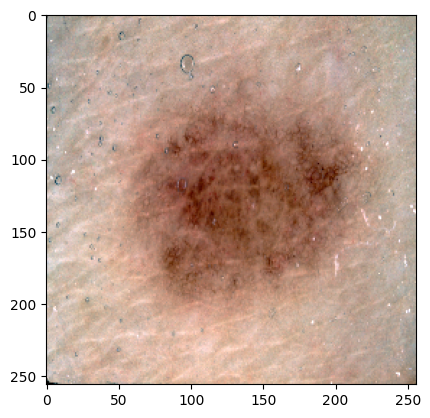

In [14]:
img = np.load(os.path.join('./datasets',config['dataset'],'images',valid_img))
plt.imshow(img.transpose(1,2,0))
plt.show()

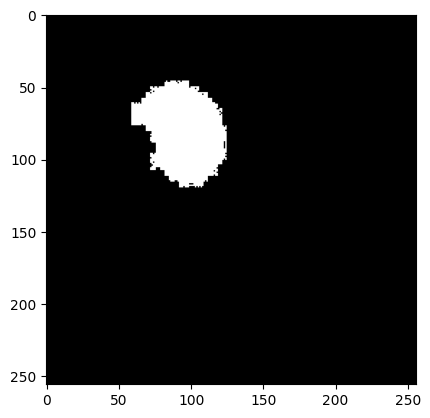

In [15]:
mask = np.load(os.path.join('./datasets',config['dataset'],'masks',valid_img))
plt.imshow(mask.transpose(1,2,0),cmap = "gray")
plt.show()

In [16]:
mask.shape
img.shape

(3, 256, 256)

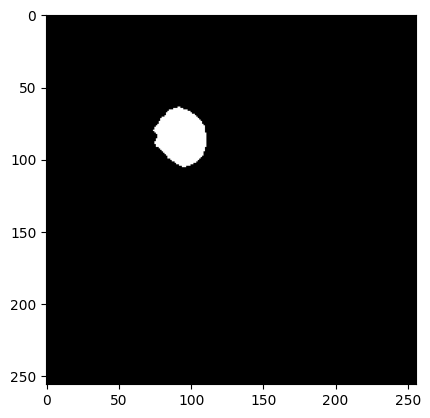

In [17]:
model.eval()
model = model.to('cuda')
img1 = torch.Tensor(img).unsqueeze(0).cuda()
pred = model(img1)
# pred = torch.softmax(pred,dim=1)
pred = pred.squeeze(0).detach().cpu().numpy()

sub_pred = pred[0:1,:,:]
plt.imshow(sub_pred.transpose(1,2,0)>0.5,cmap = "gray")
plt.show()

# sub_pred = pred[1:2,:,:]
# plt.imshow(sub_pred.transpose(1,2,0)>0.5,cmap = "gray")
# plt.show()

# sub_pred = pred[2:3,:,:]

In [28]:
def save_all_test(model,img,mask):
    model.eval()
    model = model.cuda()
    img1 = torch.Tensor(img).unsqueeze(0).cuda()
    pred = model(img1)
    pred = pred.squeeze(0).detach().cpu().numpy()
    sub_pred = pred[2:3,:,:]
    if not os.path.exists(config['result_img_dir_valid']):
        os.makedirs(config['result_img_dir_valid'])
    plt.imsave(os.path.join(config['result_img_dir_valid'] ,'AdaptiveScale_with_unet.png'),(sub_pred > 0.5)[0],cmap='gray')

In [ ]:
from tqdm import tqdm
pbar = tqdm(total=len(valid_img_ids))
for valid_img in valid_img_ids:
    img = np.load(os.path.join('./datasets',config['dataset'],'images',valid_img))
    mask = np.load(os.path.join('./datasets',config['dataset'],'masks',valid_img))

    config['result_img_dir_valid'] = os.path.join(result_img_dir,valid_img.split('.')[0])
    save_all_test(model,img,mask)
    postfix = OrderedDict([
        ('loss', 0)
    ])
    pbar.set_postfix(postfix)
    pbar.update(1)
pbar.close()

 32%|███▏      | 167/519 [00:02<00:06, 53.12it/s, loss=0]

## CAM

In [18]:
result_img_dir = os.path.join('./result_img',config['dataset'])
valid_img_ids = np.load(os.path.join('./datasets',config['dataset'],'valid_img_ids.npy'))
valid_img = valid_img_ids[112]
print(valid_img)

cju0vtox5ain6099360pu62rp.npy


1.0


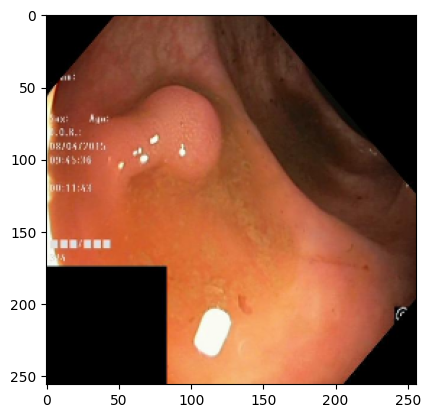

In [19]:
origin_img = np.load(os.path.join('./datasets',config['dataset'],'images',valid_img))
plt.imshow(origin_img.transpose(1,2,0))
print(origin_img.max())
plt.show()

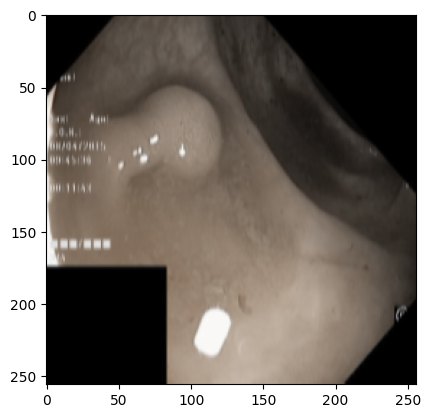

In [20]:
import cv2
img_blur = cv2.GaussianBlur(origin_img, (5, 5), 1.1)
plt.imshow(img_blur.transpose(1,2,0))
plt.show()

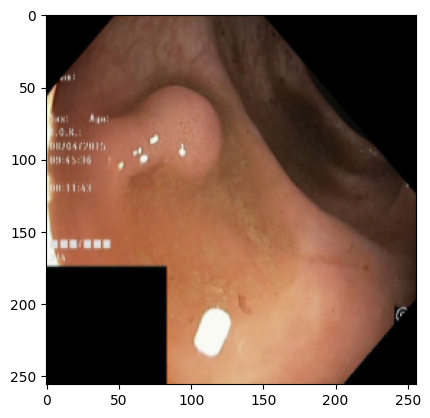

In [21]:
img_blur = cv2.GaussianBlur(origin_img, (7, 7), 1.1)
plt.imshow(origin_img.transpose(1,2,0)*0.6 + img_blur.transpose(1,2,0)*0.4)
plt.show()

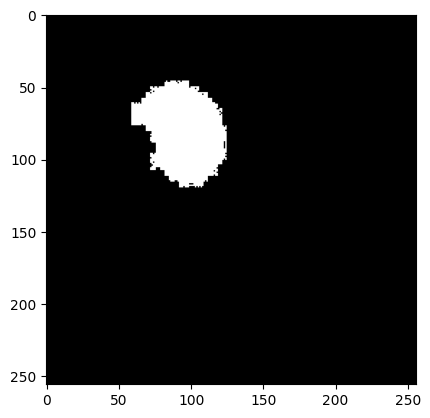

In [22]:
mask = np.load(os.path.join('./datasets',config['dataset'],'masks',valid_img))
plt.imshow(mask.transpose(1,2,0),cmap = "gray")
plt.show()

0.70000005 (1, 256, 256)


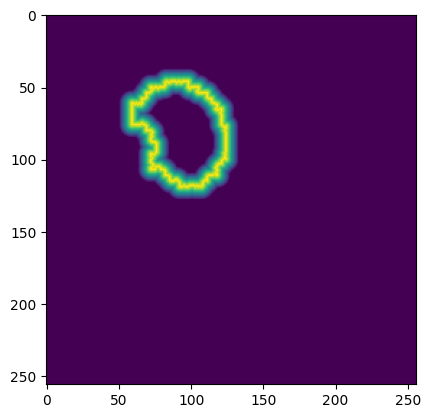

In [23]:
thresholds = np.load(os.path.join('./datasets',config['dataset'],'thresholds',valid_img))
print(thresholds.max(),thresholds.shape)
plt.imshow(thresholds.transpose(1,2,0))
plt.show()

1.0 (1, 256, 256)


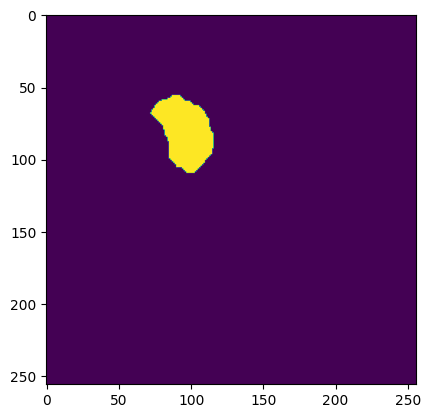

In [24]:
shrink = np.load(os.path.join('./datasets',config['dataset'],'shrinks',valid_img))
print(shrink.max(),shrink.shape)
plt.imshow(shrink.transpose(1,2,0))
plt.show()

1.4864922 -9.59577


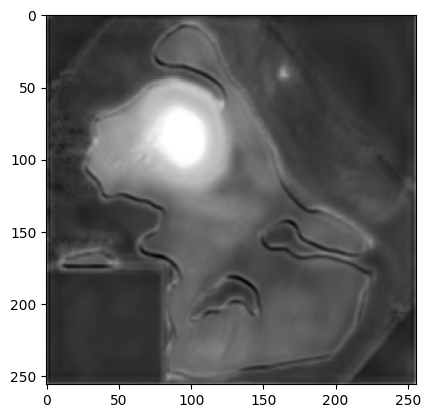

0.41587222 -0.5663214


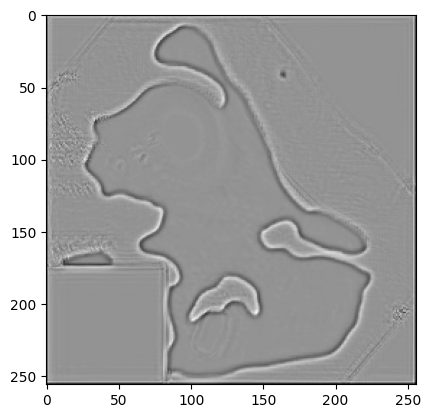

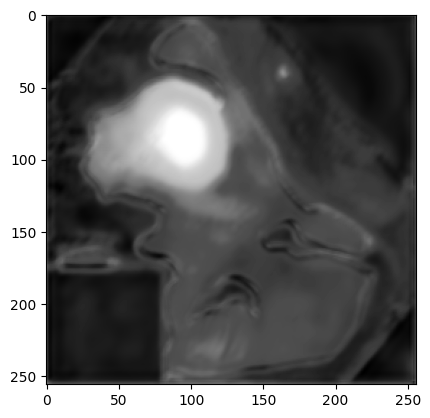

In [25]:
model.eval()
# model = model.cuda()
model = model.to('cuda')
img1 = torch.Tensor(origin_img).unsqueeze(0).cuda()
# img1 = torch.Tensor(origin_img).unsqueeze(0)
pred = model(img1)
# pred = torch.softmax(pred,dim=1)
pred = pred.squeeze(0).detach().cpu().numpy()

sub_pred = pred[0:1,:,:]
print(sub_pred.max(),sub_pred.min())
plt.imshow(sub_pred.transpose(1,2,0),cmap = "gray")
plt.show()

sub_pred = pred[1:2,:,:]
print(sub_pred.max(),sub_pred.min())
plt.imshow(sub_pred.transpose(1,2,0),cmap = "gray")
plt.show()

sub_pred = pred[2:3,:,:]
plt.imshow(sub_pred.transpose(1,2,0),cmap = "gray")
plt.show()

0.0


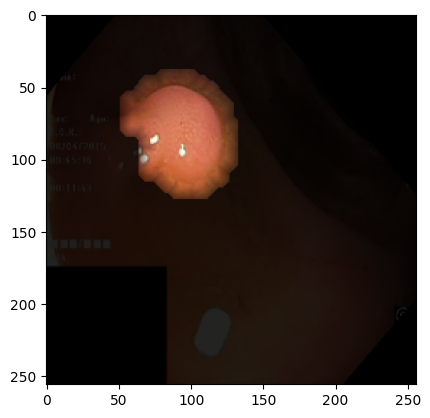

(256, 256) 251


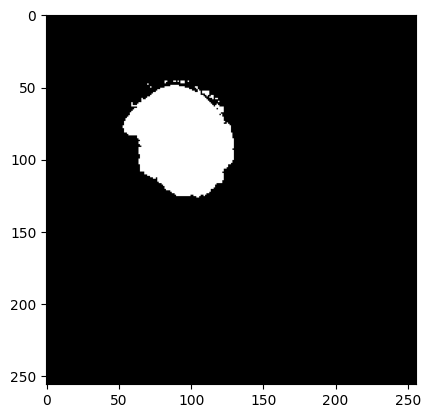

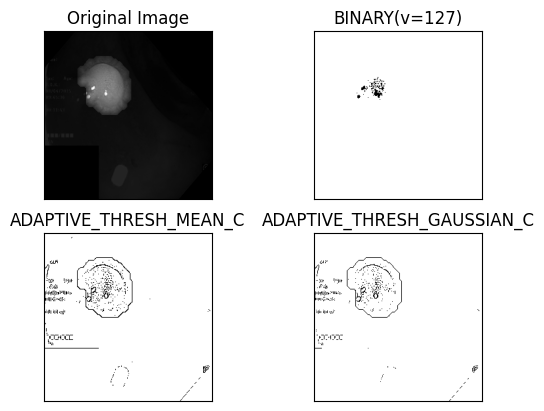

In [38]:
import cv2 as cv
from matplotlib import pyplot as plt
thredholding_path = os.path.join(result_img_dir,valid_img.split('.')[0])
# sub_pred = (pred[2:3,:,:]>0.5) * origin_img   # 不要背景
# sub_pred = (pred[2:3,:,:])*0.05 * origin_img + origin_img*0.65 # 保留背景
# sub_pred = (pred[2:3,:,:]>0) * origin_img*0.2 + origin_img*0.8
# sub_pred = (0.01*pred[2:3,:,:]) + origin_img

# sub_pred = np.maximum(mask*0.7, thresholds) * origin_img/0.7
sub_pred = np.maximum(mask*0.7, thresholds)
sub_pred[sub_pred == 0.3] = 0.1     # 背景变黑
sub_pred = sub_pred * origin_img/0.7
# sub_pred[sub_pred<=0] = 1
print(sub_pred.min())
img = sub_pred.transpose(1,2,0)*255.0
img = np.uint8(img)
plt.imshow(img, cmap='gray')
plt.imsave(os.path.join(thredholding_path ,'thredholding_with_unet_black.png'),img)
plt.show()

img= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print(img.shape,img.max())
ret, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, 3)
th3 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 3, 3)
t2,otsu = cv.threshold(img,127,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(otsu,cmap='gray')
plt.show()
titles = ['Original Image', 'BINARY(v=127)',
          'ADAPTIVE_THRESH_MEAN_C', 'ADAPTIVE_THRESH_GAUSSIAN_C']
images = [img, 255-th1, th2, th3]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i],cmap='gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

In [180]:
import cv2
def draw_attn_in_image(attn_map, img):
    pos_max = attn_map.max()
    attn_map = attn_map/pos_max
    attn_map = (attn_map * 255).astype(np.uint8)
    attn_map = cv2.applyColorMap(attn_map, cv2.COLORMAP_JET)
    attn_map = np.transpose(attn_map,(2,0,1))
    attn_map = img + attn_map * 0.6
    attn_map = attn_map.astype(np.uint8)
    return attn_map

(1, 256, 256) (256, 256)


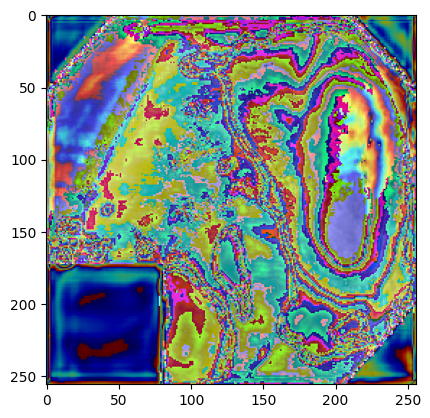

In [146]:
sub_pred = pred[0:1,:,:]
print(sub_pred.shape,img.shape)
attn_map = draw_attn_in_image(sub_pred[0],np.uint(img*255.0))
plt.imshow(attn_map.transpose(1,2,0),cmap='gray')
plt.show()

(1, 256, 256) (256, 256)


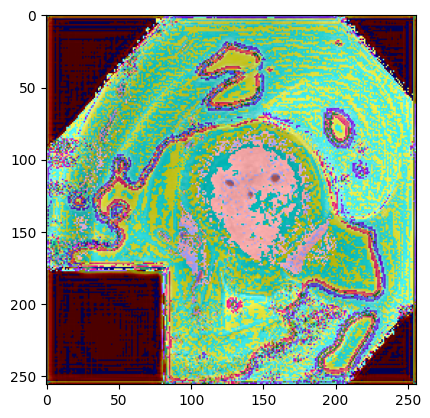

In [43]:
sub_pred = pred[1:2,:,:]
print(sub_pred.shape,img.shape)
attn_map = draw_attn_in_image(sub_pred[0],np.uint(img*255.0))
plt.imshow(attn_map.transpose(1,2,0),cmap='gray')
plt.show()

In [181]:
def save_all_cam(model,img,mask):
    model.eval()
    model = model.cuda()
    img1 = torch.Tensor(img).unsqueeze(0).cuda()
    pred = model(img1)
    pred = pred.squeeze(0).detach().cpu().numpy()
    shrink_attn = pred[0:1,:,:]
    shrink_attn = draw_attn_in_image(shrink_attn[0],np.uint(img*255.0))
    thresh_attn = pred[1:2,:,:]
    thresh_attn = draw_attn_in_image(thresh_attn[0],np.uint(img*255.0))
    pred_attn = pred[2:3,:,:]
    pred_attn = draw_attn_in_image(pred_attn[0],np.uint(img*255.0))


    # sub_pred = (pred[2:3,:,:]>0) * img*0.2 + img*0.5
    # sub_pred = (pred[2:3,:,:]>0) * img*0.2 + img*0.8
    sub_pred = (pred[2:3,:,:])*0.05 * img + img*0.75 # 保留背景
    # sub_pred = (0.01*pred[2:3,:,:]) + origin_img
    sub_pred = sub_pred.transpose(1,2,0)*255.0
    sub_pred = np.uint8(sub_pred)
    # plt.imshow(sub_pred, cmap='gray')
    plt.imsave(os.path.join(config['result_img_dir_valid'] ,'thredholding_with_unet.png'),sub_pred)

    if not os.path.exists(config['result_img_dir_valid']):
        os.makedirs(config['result_img_dir_valid'])
    plt.imsave(os.path.join(config['result_img_dir_valid'] ,'shrink_attn_AdaptiveScale_with_unet.png'),shrink_attn.transpose(1,2,0))
    plt.imsave(os.path.join(config['result_img_dir_valid'] ,'thresh_attn_AdaptiveScale_with_unet.png'),thresh_attn.transpose(1,2,0))
    plt.imsave(os.path.join(config['result_img_dir_valid'] ,'pred_attn_AdaptiveScale_with_unet.png'),pred_attn.transpose(1,2,0))

In [182]:
from tqdm import tqdm
pbar = tqdm(total=len(valid_img_ids))
for valid_img in valid_img_ids:
    img = np.load(os.path.join('./datasets',config['dataset'],'images',valid_img))
    mask = np.load(os.path.join('./datasets',config['dataset'],'masks',valid_img))

    config['result_img_dir_valid'] = os.path.join(result_img_dir,valid_img.split('.')[0])
    save_all_cam(model,img,mask)
    postfix = OrderedDict([
        ('loss', 0)
    ])
    pbar.set_postfix(postfix)
    pbar.update(1)
pbar.close()

100%|██████████| 200/200 [00:34<00:00,  5.76it/s, loss=0]


# get cost time

In [15]:
def get_all_cost_time(model,img,mask):
    model.eval()
    model = model.cuda()
    img1 = torch.Tensor(img).unsqueeze(0).cuda()
    pred = model(img1)
    pred = pred.squeeze(0).detach().cpu().numpy()
    

In [16]:
from tqdm import tqdm
pbar = tqdm(total=len(valid_img_ids))
start_time = time.time()
for valid_img in valid_img_ids:
    img = np.load(os.path.join('./datasets',config['dataset'],'images',valid_img))
    mask = np.load(os.path.join('./datasets',config['dataset'],'masks',valid_img))

    config['result_img_dir_valid'] = os.path.join(result_img_dir,valid_img.split('.')[0])
    get_all_cost_time(model,img,mask)
    postfix = OrderedDict([
        ('loss', 0)
    ])
    pbar.set_postfix(postfix)
    pbar.update(1)
pbar.close()
end_time = time.time()
print(end_time-start_time)

100%|██████████| 519/519 [00:04<00:00, 127.59it/s, loss=0]

4.068449258804321
